In [1]:
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
train = pd.read_csv('glaucoma_train.csv')
test = pd.read_csv('glaucoma_test.csv')
train

,filename,label,path,label_encoded
0,05_g.jpg,glaucoma,HRF_GLAUCOMA/05_g.jpg,1
1,14_g.jpg,glaucoma,HRF_GLAUCOMA/14_g.jpg,1
2,01_g.jpg,glaucoma,HRF_GLAUCOMA/01_g.jpg,1
3,06_g.jpg,glaucoma,HRF_GLAUCOMA/06_g.jpg,1
4,04_g.jpg,glaucoma,HRF_GLAUCOMA/04_g.jpg,1
...,...,...,...,...
970,NL_220.png,normal,kaggle_ds/1_normal/NL_220.png,0
971,NL_154.png,normal,kaggle_ds/1_normal/NL_154.png,0
972,NL_002.png,normal,kaggle_ds/1_normal/NL_002.png,0
973,NL_080.png,normal,kaggle_ds/1_normal/NL_080.png,0


In [3]:
train.groupby('label').count()

,filename,path,label_encoded
label,,,
glaucoma,243,243,243
normal,732,732,732


In [4]:
NUM_SAMPLE = 500
train_balanced = pd.DataFrame(columns=train.columns)

for label in train['label'].unique():
    sub_df = train[train['label'] == label]
    sub_df_fixed = sub_df.copy()

    duplicate_n = int(NUM_SAMPLE / len(sub_df))
    for _ in range(duplicate_n): sub_df = sub_df.append(sub_df_fixed, ignore_index=True)

    sub_df = sub_df.sample(NUM_SAMPLE)
    train_balanced = train_balanced.append(sub_df, ignore_index=True)

train_balanced

,filename,label,path,label_encoded
0,09_g.jpg,glaucoma,HRF_GLAUCOMA/09_g.jpg,1
1,Glaucoma_010.png,glaucoma,kaggle_ds/2_glaucoma/Glaucoma_010.png,1
2,Im0511_g_ORIGA.jpg,glaucoma,ORIGA_GLAUCOMA/Im0511_g_ORIGA.jpg,1
3,Im0644_g_ORIGA.jpg,glaucoma,ORIGA_GLAUCOMA/Im0644_g_ORIGA.jpg,1
4,Glaucoma_085.png,glaucoma,kaggle_ds/2_glaucoma/Glaucoma_085.png,1
...,...,...,...,...
995,NL_085.png,normal,kaggle_ds/1_normal/NL_085.png,0
996,Im0213_ORIGA.jpg,normal,ORIGA_NORMAL/Im0213_ORIGA.jpg,0
997,Im0350_ORIGA.jpg,normal,ORIGA_NORMAL/Im0350_ORIGA.jpg,0
998,NL_125.png,normal,kaggle_ds/1_normal/NL_125.png,0


In [5]:
NUM_TRAIN = len(train_balanced)
train_balanced = train_balanced.sample(NUM_TRAIN)

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_balanced['path'], train_balanced['label_encoded'].astype(int))).cache().shuffle(NUM_TRAIN)
test_ds = tf.data.Dataset.from_tensor_slices((test['path'], test['label_encoded'])).cache()

IMG_DIM = 380

def import_image(path, label):
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(path)
    img = tf.image.decode_png(img)
    img = tf.image.convert_image_dtype(img, tf.float32)

    dim = tf.reduce_max(tf.shape(img))
    img = tf.image.resize_with_crop_or_pad(img, dim, dim)
    img = tf.image.resize(img, [IMG_DIM, IMG_DIM])

    return img, label

train_ds = train_ds.map(import_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(import_image, num_parallel_calls=AUTOTUNE)

tf.Tensor(0.0, shape=(), dtype=float32)


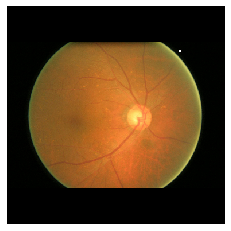

In [8]:
for img, label in train_ds.take(1):
    print(label)
    plt.imshow(img)
    plt.axis('off')

In [9]:
ROTATE_ANGLE = 10/180 * math.pi

def image_augment(img, label):
    batch_size = tf.shape(img)[0]

    img = tf.image.random_flip_left_right(img)
    img = tfa.image.rotate(img, tf.random.uniform([batch_size], minval=-ROTATE_ANGLE, maxval=ROTATE_ANGLE)[0])
    
    # img = tf.image.resize(img, [600, 600])
    # img = tf.image.random_crop(img, [batch_size, IMG_DIM, IMG_DIM, 3])

    # img = tfa.image.random_cutout(img, (100, 100))

    return img, label

In [10]:
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE).map(image_augment)
test_ds = test_ds.batch(BATCH_SIZE)

tf.Tensor(0.0, shape=(), dtype=float32)


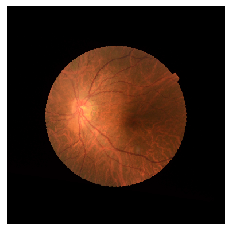

In [11]:
for img, label in train_ds.take(1):
    print(label[0])
    plt.imshow(img[0])
    plt.axis('off')

In [12]:
TF_HUB_MODEL = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'
hub_layer = hub.KerasLayer(TF_HUB_MODEL, trainable=False)

model = tf.keras.Sequential([
    hub_layer,
    # tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build([None, IMG_DIM, IMG_DIM, 3])  # Batch input shape.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 1)                 1793      
Total params: 17,675,609
Trainable params: 1,793
Non-trainable params: 17,673,816
_________________________________________________________________


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['acc']
)

In [15]:
history = model.fit(
    train_ds,
    epochs=1,
    validation_data=test_ds,
)

32/32 [==============================] - 22s 694ms/step - loss: 0.6995 - acc: 0.5130 - val_loss: 0.6922 - val_acc: 0.5100


In [16]:
hub_layer.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 1)                 1793      
Total params: 17,675,609
Trainable params: 17,550,409
Non-trainable params: 125,200
_________________________________________________________________


In [17]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
32/32 [==============================] - 21s 664ms/step - loss: 0.6757 - acc: 0.6170 - val_loss: 0.6834 - val_acc: 0.5700
Epoch 2/10
32/32 [==============================] - 22s 675ms/step - loss: 0.6552 - acc: 0.6780 - val_loss: 0.6788 - val_acc: 0.5500
Epoch 3/10
32/32 [==============================] - 21s 652ms/step - loss: 0.6407 - acc: 0.6820 - val_loss: 0.6774 - val_acc: 0.5600
Epoch 4/10
32/32 [==============================] - 21s 669ms/step - loss: 0.6301 - acc: 0.6820 - val_loss: 0.6731 - val_acc: 0.5700
Epoch 5/10
32/32 [==============================] - 21s 660ms/step - loss: 0.6200 - acc: 0.6980 - val_loss: 0.6672 - val_acc: 0.6000
Epoch 6/10
32/32 [==============================] - 22s 686ms/step - loss: 0.6159 - acc: 0.6950 - val_loss: 0.6765 - val_acc: 0.5300
Epoch 7/10
32/32 [==============================] - 22s 684ms/step - loss: 0.6048 - acc: 0.6920 - val_loss: 0.6785 - val_acc: 0.6200
Epoch 8/10
32/32 [==============================] - 21s 666ms/step - 

In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
)

In [17]:
model.save_weights('hi')

In [18]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
)

Epoch 1/100
9/9 [==============================] - 4s 429ms/step - loss: 0.3779 - acc: 0.8317 - val_loss: 0.4335 - val_acc: 0.8250
Epoch 2/100
9/9 [==============================] - 4s 426ms/step - loss: 0.3718 - acc: 0.8489 - val_loss: 0.4340 - val_acc: 0.8250
Epoch 3/100
9/9 [==============================] - 4s 427ms/step - loss: 0.3603 - acc: 0.8585 - val_loss: 0.4358 - val_acc: 0.8250
Epoch 4/100
9/9 [==============================] - 4s 421ms/step - loss: 0.3721 - acc: 0.8547 - val_loss: 0.4340 - val_acc: 0.8250
Epoch 5/100
9/9 [==============================] - 4s 412ms/step - loss: 0.3701 - acc: 0.8337 - val_loss: 0.4327 - val_acc: 0.8250
Epoch 6/100
9/9 [==============================] - 4s 447ms/step - loss: 0.3680 - acc: 0.8470 - val_loss: 0.4314 - val_acc: 0.8250
Epoch 7/100
9/9 [==============================] - 4s 417ms/step - loss: 0.3706 - acc: 0.8470 - val_loss: 0.4316 - val_acc: 0.8250
Epoch 8/100
9/9 [==============================] - 4s 420ms/step - loss: 0.3724 - a

In [19]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
)

Epoch 1/100
9/9 [==============================] - 4s 433ms/step - loss: 0.3582 - acc: 0.8566 - val_loss: 0.4175 - val_acc: 0.8250
Epoch 2/100
9/9 [==============================] - 4s 434ms/step - loss: 0.3541 - acc: 0.8681 - val_loss: 0.4165 - val_acc: 0.8250
Epoch 3/100
9/9 [==============================] - 4s 417ms/step - loss: 0.3632 - acc: 0.8413 - val_loss: 0.4183 - val_acc: 0.8250
Epoch 4/100
9/9 [==============================] - 4s 427ms/step - loss: 0.3606 - acc: 0.8566 - val_loss: 0.4202 - val_acc: 0.8250
Epoch 5/100
9/9 [==============================] - 4s 444ms/step - loss: 0.3564 - acc: 0.8585 - val_loss: 0.4209 - val_acc: 0.8250
Epoch 6/100
9/9 [==============================] - 4s 434ms/step - loss: 0.3567 - acc: 0.8432 - val_loss: 0.4209 - val_acc: 0.8250
Epoch 7/100
9/9 [==============================] - 4s 434ms/step - loss: 0.3607 - acc: 0.8489 - val_loss: 0.4188 - val_acc: 0.8250
Epoch 8/100
9/9 [==============================] - 4s 427ms/step - loss: 0.3496 - a

In [22]:
history = model.fit(
    train_ds.repeat(count=50),
    epochs=10,
    validation_data=test_ds,
)

Epoch 1/10
450/450 [==============================] - 209s 465ms/step - loss: 0.3305 - acc: 0.8736 - val_loss: 0.3948 - val_acc: 0.8750
Epoch 2/10
450/450 [==============================] - 208s 463ms/step - loss: 0.3283 - acc: 0.8722 - val_loss: 0.3920 - val_acc: 0.8500
Epoch 3/10
450/450 [==============================] - 208s 462ms/step - loss: 0.3236 - acc: 0.8746 - val_loss: 0.3908 - val_acc: 0.8500
Epoch 4/10
450/450 [==============================] - 211s 469ms/step - loss: 0.3195 - acc: 0.8764 - val_loss: 0.3899 - val_acc: 0.8500
Epoch 5/10
450/450 [==============================] - 208s 463ms/step - loss: 0.3185 - acc: 0.8787 - val_loss: 0.3886 - val_acc: 0.8250
Epoch 6/10
450/450 [==============================] - 205s 455ms/step - loss: 0.3148 - acc: 0.8825 - val_loss: 0.3889 - val_acc: 0.8500
Epoch 7/10
450/450 [==============================] - 205s 455ms/step - loss: 0.3113 - acc: 0.8839 - val_loss: 0.3870 - val_acc: 0.8500
Epoch 8/10
450/450 [============================

In [23]:
model.save_weights('hello2')